# MIMIQ demo - Surface Code
QPerfect 2025 https://qperfect.io/

The interactive version of this demo can be found at https://github.com/qperfect-io/MimiqDemos/blob/main/SurfaceCode/surfacecode.ipynb

## Introduction and context

Quantum error correction (QEC) codes are the cornerstone of building reliable quantum computers. They are ingenious quantum algorithms that transform multiple noisy qubits into a smaller number of more robust qubits. Currently, QEC codes represent the only known theoretical approach to systematically reduce noise in quantum computers in a scalable manner. Among the various QEC codes, the surface code has emerged as a frontrunner for practical implementation. Its popularity stems from its high error threshold and compatibility with two-dimensional qubit architectures.

The surface code arranges physical qubits in a two-dimensional lattice, where data qubits store quantum information and ancilla qubits are used to detect errors through parity measurements. While researchers often use simplified Pauli-based noise models to demonstrate the code's effectiveness mathematically, quantitative assessment of these codes in realistic scenarios, including non-Pauli noise, requires sophisticated numerical simulations.

In this demo, we'll use MIMIQ to implement the rotated ZXXZ surface code, recently demonstrated experimentally by Google Quantum AI [Nature 614, 676-681 (2023)]. As a proof of concept, we'll execute full error correction cycles, including measurement operations, without incorporating errors. If you like you can easily add them yourself using MIMIQ's noisy simulations functionality: https://docs.qperfect.io/mimiqcircuits-python/manual/noise.html. By optimizing the Matrix Product State (MPS) representation, we'll push the boundaries of full state simulations up to distance 9, corresponding to an impressive 161 qubits.

### The Surface Code: A Closer Look

The rotated ZXXZ surface code encodes logical qubits in entangled states of d² physical qubits, with an additional d²-1 auxiliary qubits for parity measurements. Here's how it works:

- Lattice Preparation: We arrange d² physical qubits for each logical qubit in a 2D grid, complemented by d²-1 auxiliary qubits for parity measurements. Data qubits are initialized in an eigenstate of half the ZXXZ stabilizers, aligning with either a logical Z state or a logical X state.
- Error Correction Cycles: Each cycle involves applying CZ gates between each data qubit and its four nearest neighbors, interspersed with Hadamard gates. We then perform projective measurements on auxiliary qubits to detect errors.
- Error decoding: Measurement results are used to identify potential errors which can then be corrected, either by direct feedback or by corrections applied in post-processing.
- Repetition: Error correction cycles continue throughout the computation, with periodic verification of the logical state and application of necessary logical operations.

### MIMIQ Features used in this demo
- Midcircuit measurements
- Qubit ordering
- Large bond dimension

## MIMIQ implementation

Let's begin by importing the necessary packages and establishing a connection to the MIMIQ service.

In [1]:
from mimiqcircuits import *
import matplotlib.pyplot as plt
import numpy as np
from time import sleep

# create a connection to the MIMIQ server
conn = MimiqConnection()
conn.connect()

Connection:
├── url: https://mimiq.qperfect.io/api
├── Computing time: 5042/10000 minutes
├── Executions: 2044/10000
├── Max time limit per request: 180 minutes
├── Default time limit is equal to max time limit: 180 minutes
└── status: open

Now we will create some essential helper functions. The surface code is implemented on a two-dimensional grid of qubits, with specific couplings between data and ancilla qubits. To manage this structure efficiently, we'll define two key functions:
1. A function to generate a list of coordinates for the data and ancilla qubits.
2. A function to generate a mapping from qubit coordinates to unique indices.
3. A function to identify pairs of qubits that meet specific nearest-neighbor criteria.

In [2]:
def zxxz_surface_code_registers(d):
    """ Generate qubit coordinates for a distance d surface code """
    data = [(x, y) for x in range(1, 2*d, 2) for y in range(1, 2*d, 2)]
    X = [(x, y) for y in range(2, 2*d, 2) for x in range(2 if y % 4 == 0 else 0, 2*d+2, 4)]
    Z = [(x, y) for x in range(2, 2*d, 2) for y in range(0 if x % 4 == 0 else 2, 2*d+2, 4)]
    return data, X, Z

def qubit_map(*coordinates, ordering=None):
    """
    Generate a dictionary mapping qubit coordinates to unique indices.

    This function takes an arbitrary number of coordinate lists and creates a
    mapping from each coordinate to a unique index. By default the qubits are 
    sorted from top-left to bottom-right (first by x, then by y).
    """
    # sorting function
    if ordering is None:
        ordering = lambda coord: (coord[0], coord[1])
        
    # Collect all qubit coordinates into a single list
    all_qubits = [coord for coord_list in coordinates for coord in coord_list]
    
    # Sort qubits from top-left to bottom-right
    sorted_qubits = sorted(all_qubits, key=ordering)
    
    # Create and return dictionary mapping coordinates to unique indices
    return {coord: index for index, coord in enumerate(sorted_qubits)}

def get_pairs(qcoords1, targets):
    """
    Find pairs of neighboring coordinates.

    This function identifies pairs of coordinates from two sets in
    a given direction. 
 
    targets = {dir1:coords1, dir2:coords2...}
    """
    offsets = {'SE': (1, 1), 'SW': (-1, 1), 'NE': (1, -1), 'NW': (-1, -1)}
    sub1, sub2 = [], []

    for direction,qcoords2 in targets.items():
        dx, dy = offsets[direction]
        for (x, y) in qcoords1:
            for (ax, ay) in qcoords2:
                if (ax - x, ay - y) == (dx, dy):
                    sub1.append((x,y))
                    sub2.append((ax,ay))
                    break
    return sub1, sub2

As an example, let's plot the coordinates for a distance 5 surface code

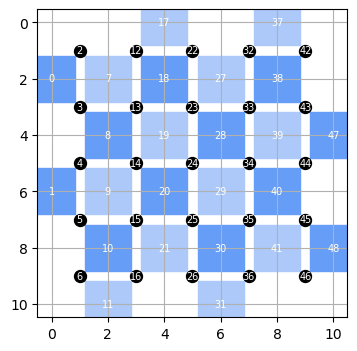

In [3]:
def plot_zxxz(data, X, Z, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
        
    s = ax.get_figure().get_size_inches()[1]**2.6
    ax.scatter(*zip(*X), marker='s', color='#669DF6', s=30*s, label='X Ancilla')
    ax.scatter(*zip(*Z), marker='s', color='#ACC9F9', s=30*s, label='Z Ancilla')
    ax.scatter(*zip(*data), marker='o', color='k', s=2*s, label='Data')

    ax.axis('equal')  # Ensure square aspect ratio
    ax.invert_yaxis()  # Invert the y-axis
    ax.grid(True)

# make a qubit placement plot for a d=5 surface code
data, X, Z = zxxz_surface_code_registers(5)
qmap = qubit_map(data,X,Z)
fig, ax = plt.subplots(figsize=(4, 4))
plot_zxxz(data, X, Z, ax=ax)
for (x, y), num in qmap.items():
    ax.annotate(str(num), (x, y), color='w', size=7,
                horizontalalignment='center',
                verticalalignment='center')
plt.show()

The white numbers indicate the index of each qubit in the circuit. We can also visualize the stabilizer gates

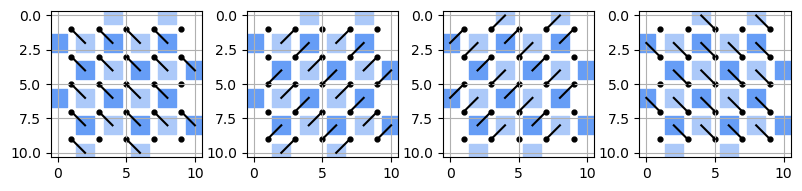

In [4]:
def plot_zxxz_pairs(ax, targets):
    plot_zxxz(data, X, Z, ax)
    list1, list2 = get_pairs(data, targets)
    for (x1, y1), (x2, y2) in zip(list1, list2):
        ax.plot([x1, x2], [y1, y2], 'k-')

fig, axes = plt.subplots(1, 4, figsize=(8,2))

plot_zxxz_pairs(axes[0], {'SE':X+Z})
plot_zxxz_pairs(axes[1], {'SW':Z, 'NE':X})
plot_zxxz_pairs(axes[2], {'SW':X, 'NE':Z})
plot_zxxz_pairs(axes[3], {'NW':X+Z})

plt.tight_layout()
plt.show()

Now, let's define the core function that constructs the quantum circuit for the ZXXZ surface code. This function:
1. Takes an odd integer 'd' as input, representing the code distance.
2. Generates the coordinates for data qubits, X ancilla qubits, and Z ancilla qubits.
3. Constructs the quantum circuit by adding gates for 'd' error correction cycles.

In [5]:
def zxxz_surface_code(d, rounds = None, init = 'X', meas = 'X', ordering = None):
    """
    Implement ZXXZ rotated surface code of distance d.
    
    This function generates a quantum circuit for the ZXXZ rotated surface code,
    as described in [Nature 614, 676–681 (2023)] with d rounds of error correction
    """
    if rounds == None: rounds = d
    # generate coordinates for data, x and z ancilla qubits
    data, X, Z = zxxz_surface_code_registers(d)
    qmap = qubit_map(data, X, Z, ordering=ordering) # Map coordinates to qubit indices
    n = len(X + Z) # number of ancilla for measurements

    def q(coords):
        """Convert coordinates to qubit indices."""
        return [qmap[c] for c in coords]
    
    def p(coords1, targets):
        """Get control and target qubit index pairs."""
        c, t = get_pairs(coords1, targets)
        return q(c), q(t)
        
    # Initialize circuit
    circ = Circuit()
    if init == "X": 
        circ.push(GateH(), q(data[::2])) 
    else: 
        circ.push(GateH(), q(data[1::2])) 
    
    # Quantum error correction cycles
    for t in range(rounds):
        # Hadamard on ancilla qubits
        circ.push(GateH(), q(X + Z))

        # Stabilizer measurement cycles
        circ.push(GateCZ(), *p(data, {'SE':X+Z}))
        
        circ.push(GateH(), q(data))
        
        circ.push(GateCZ(), *p(data, {'SW':X, 'NE':Z}))
        circ.push(GateCZ(), *p(data, {'SW':Z, 'NE':X}))
        
        circ.push(GateH(), q(data))

        circ.push(GateCZ(), *p(data, {'NW':X+Z}))
        
        if t == rounds - 1:
            if meas == "X":
                circ.push(GateH(), q(data[::2]))
            else: 
                circ.push(GateH(), q(data[1::2]))
                
        circ.push(GateH(), q(X + Z))
        circ.push(Measure(), q(X + Z), range(t*n, t*n+n)) 

    return circ

### Distance 5 surface code (49 qubits)
Now we are ready to perform our simulation. In the following we will time how long it takes to execute the surface code error correction cycle for distance $d=5$ (corresponding to 49 qubits) and various bond dimensions up to 256 and a fixed entanglement dimension of 4. We'll run each simulation 10 times to get the average run time and fidelity.

In [6]:
def submit_job(circuit, bonddims=[64], nsamples=1, entdim=4, **kwargs):
    expt = {'jobs':[], 'bonddims':bonddims, 'nsamples':nsamples, 
            'd':d, 'nqubits':circuit.num_qubits(), 'ngates':len(circuit), **kwargs}
    for bd in bonddims:
        job = conn.execute(circuit, algorithm="mps", nsamples=nsamples, bonddim=bd, entdim=entdim, **kwargs)
        expt['jobs'].append(job)
        sleep(1)
    return expt

d = 5
circuit = zxxz_surface_code(d)
expt = submit_job(circuit, bonddims=[4,8,16,32,64,128,256], nsamples=10)

In [11]:
def get_results(expt):
    print(f"Distance: {expt['d']} (surface code)")
    print(f"Number of qubits: {expt['nqubits']}")
    print(f"Number of gates: {expt['ngates']}")
    print(f"{'-'*40}")
    print(f"{'Bonddim':<8}{'Fidelity':<15}{'Time (s)':<10}")
    print(f"{'-'*40}")

    for i, job in enumerate(expt['jobs']):
        if not conn.isJobDone(job): continue
        results = conn.get_results(job)
        avg_fidelity = np.mean([r.fidelities for r in results])
        avg_time = np.mean([r.timings["total"] for r in results])
        print(f"{expt['bonddims'][i]:<8}{avg_fidelity:<15.6f}{avg_time:<10.3f}")

get_results(expt)

Distance: 5 (surface code)
Number of qubits: 49
Number of gates: 1036
----------------------------------------
Bonddim Fidelity       Time (s)  
----------------------------------------
4       0.000000       2.648     
8       0.000000       34.550    
16      0.000000       15.678    
32      0.000000       38.307    
64      0.011236       77.357    
128     0.233788       117.632   
256     1.000000       154.360   


## Going further with MIMIQ
Our initial results show that the simulation fidelity for the distance 5 surface code reaches 1 for a bond dimension of 256 or higher, and takes roughly 15 seconds/run. Not bad for a 49 qubit circuit - that is out of reach of statevector simulators, even running on HPCs. But is this the best we can do? 

Matrix product state (MPS) simulators are inherently based on a 1D representation. Though MIMIQ natively supports arbitrary connectivity, 2D problems, like surface codes, can be challenging. Fortunately, the surface code circuit, much like many quantum algorithms, has a highly structured nature that we can exploit. 

In the following we will show how to achieve dramatically better performance by carefully selecting a qubit ordering that minimizes long-range entanglement. To illustrate this, let's define a qubit mapping with custom ordering, beginning at the top left and proceeding in a zig-zag pattern along the diagonal.

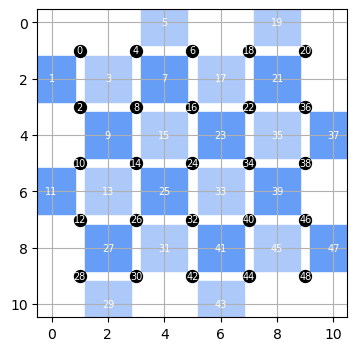

In [12]:
def custom_sort(coord):
    x, y = coord
    # define diagonals
    x, y = x + y, x - y
    if x % 4 == 2:  # Odd planes
        return (x, -y)
    else:  # Even planes
        return (x, y)

data, X, Z = zxxz_surface_code_registers(d)
qmap = qubit_map(data+X+Z, ordering=custom_sort)
fig, ax = plt.subplots(figsize=(4, 4))
plot_zxxz(data, X, Z, ax=ax)
for (x, y), num in qmap.items():
    ax.annotate(str(num), (x, y), color='w', size=7,
                horizontalalignment='center',
                verticalalignment='center')
plt.show()

We note that the resulting circuit will be identical to the one we had before, only we have assigned different indices to each of the qubits. This reordering doesn't change the quantum operations or the overall structure of the circuit. Instead, it alters how the simulator internally represents and processes the quantum state. By aligning the qubit indices more closely with the natural flow of information in the surface code, we can potentially reduce the computational resources required for simulation.

Let run it with this new ordering to see what effect this has:

### Surface code with optimized qubit ordering

In [16]:
d = 5
circuit = zxxz_surface_code(d, ordering=custom_sort)
expt = submit_job(circuit, bonddims=[4,8,16,32,64,128,256], nsamples=10)

In [18]:
get_results(expt)

Distance: 5 (surface code)
Number of qubits: 49
Number of gates: 1036
----------------------------------------
Bonddim Fidelity       Time (s)  
----------------------------------------
4       0.000000       0.586     
8       0.000000       1.523     
16      0.812623       4.328     
32      1.000000       3.198     
64      1.000000       2.430     
128     1.000000       5.390     
256     1.000000       8.652     


The results are striking! With our optimized qubit ordering, the minimum required bond dimension drops from 256 to just 32. Even more impressive, the simulation time has been slashed from 15 seconds to a mere 0.3 seconds per run. That's a 50x speedup! 

### Distance 9 surface code (161 qubits)
Let's try push MIMIQ even further and tackle an even more ambitious challenge: simulating a distance 9 surface code, which involves 161 qubits! This is well out of the reach of statevector simulators and even surpasses the capabilities of state-of-the-art quantum hardware.

In [23]:
d=9
circuit = zxxz_surface_code(d, ordering=custom_sort)
expt = submit_job(circuit, nsamples=1, bonddims=[1024])

In [24]:
get_results(expt)

Distance: 9 (surface code)
Number of qubits: 161
Number of gates: 6292
----------------------------------------
Bonddim Fidelity       Time (s)  
----------------------------------------
1024    1.000000       787.320   


## Conclusions
In this demo, we've showcased MIMIQ's ability to simulate surface codes with code distances ranging from 5 to 9, effectively handling 2D qubit arrays of up to 161 qubits, including midcircuit measurements. This performance places MIMIQ at the forefront of tensor network and MPS methods, surpassing even state-of-the-art experimental results. While this demo offers a glimpse into MIMIQ's capabilities, with MIMIQ you can do much more:

- Comprehensive QEC Simulation: MIMIQ can simulate a wide range of quantum error correcting codes, including those with non-Clifford gates.
- Realistic Noise Modeling: Going beyond Pauli approximations, MIMIQ can model the effects of physically realistic noise channels.
- Full Quantum State Analysis: MIMIQ provides access to entanglement properties and other characteristics of the full quantum state.
- Advanced Fault-Tolerant Schemes: The simulator can handle advanced fault-tolerant quantum computing schemes involving multiple logical qubits, such as magic state distillation protocols.

MIMIQ's combination of efficient MPS ansatz mapping, MPS-based circuit compression, and rapid circuit evaluation of trajectories - which can be distributed across multiple computational nodes - makes it as the tool of choice for evaluating quantum error correcting codes at the limits of classical computing. 